This notebook demonstrates a workflow connecting a reconstruction module with xgboost.

A simple encoder-decoder reconstruction machine is used. It is implemented via pytorch library.
  - A simple adaptive learning rate with step functions is implemented

Dataset is the diamond dataset coming with seaborn library.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import time
import xgboost as xgb

In [ ]:
# define encoder-decoder reconstructor
# dimensions of hidden layers (default: 128, 64) can be changed directly in the architect.
# encoder and decoder are mirrored

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [4]:
# for preparing dataloader
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [ ]:
# dataset
diamonds = sns.load_dataset('diamonds')
diamonds.shape, diamonds.dtypes

((53940, 10),
 carat       float64
 cut        category
 color      category
 clarity    category
 depth       float64
 table       float64
 price         int64
 x           float64
 y           float64
 z           float64
 dtype: object)

In [6]:
# get feature lists for numeric features, and non-numeric ones
featurelist_cat = list(diamonds.describe(exclude=np.number).keys())
featurelist_num = list(diamonds.describe(include=np.number).keys())

In [8]:
# scale numeric features
scaler = StandardScaler()
scaled_fnum = scaler.fit_transform(diamonds[featurelist_num])

In [10]:
# make a new df using the scaled version
scaled_df = pd.DataFrame(scaled_fnum, columns=featurelist_num)
X_scaled = scaled_df.drop(['price'], axis=1).values
Y_scaled = scaled_df['price'].values

In [13]:
# train-test split
seed = 123
frac_train = 0.8
X_scaled_train, X_scaled_val, Y_scaled_train, Y_scaled_val = train_test_split(X_scaled, Y_scaled, random_state=seed, train_size=frac_train)

In [14]:
# parameters for reconstructor training
batch_size = X_scaled_train.shape[0]
input_dim = X_scaled_train.shape[1] 
latent_dim = int(input_dim / 2) 
device = torch.device('cuda') # cuda or cpu
loss_fn = nn.MSELoss()
lrs = [1e-2, 1e-3, 1e-4] # learning rate, adaptive with fixed interval
epochs = [50, 50, 50]

# Create Dataset
dataset = CustomDataset(X_scaled_train, Y_scaled_train)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Instantiate model
model_encoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)  # Move model to GPU

In [18]:
tic = time.time()
# Training loop
epoch_count = 0
for ii, lr in enumerate(lrs):
    optimizer = optim.Adam(model_encoder.parameters(), lr=lr, weight_decay=0.001) # optimizer called for each new learning rate
    for epoch in range(epochs[ii]):
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            reconstructed = model_encoder(data)
            loss = loss_fn(reconstructed, data)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch_count+1}, Loss: {loss.item()}")
        epoch_count += 1
toc = time.time()
print(f'Training took {toc - tic} seconds.\n')

Epoch 1, Loss: 0.6886563301086426
Epoch 2, Loss: 0.6914652585983276
Epoch 3, Loss: 0.8071809411048889
Epoch 4, Loss: 0.6825230717658997
Epoch 5, Loss: 0.6966428160667419
Epoch 6, Loss: 0.7041495442390442
Epoch 7, Loss: 0.705832839012146
Epoch 8, Loss: 0.7021447420120239
Epoch 9, Loss: 0.6966843605041504
Epoch 10, Loss: 0.6914052963256836
Epoch 11, Loss: 0.6865072846412659
Epoch 12, Loss: 0.6842580437660217
Epoch 13, Loss: 0.6841930150985718
Epoch 14, Loss: 0.6864630579948425
Epoch 15, Loss: 0.6865231394767761
Epoch 16, Loss: 0.6833882927894592
Epoch 17, Loss: 0.6822190880775452
Epoch 18, Loss: 0.6820082664489746
Epoch 19, Loss: 0.6822628378868103
Epoch 20, Loss: 0.6826186180114746
Epoch 21, Loss: 0.6826055645942688
Epoch 22, Loss: 0.6820764541625977
Epoch 23, Loss: 0.6811921000480652
Epoch 24, Loss: 0.6802019476890564
Epoch 25, Loss: 0.6792688965797424
Epoch 26, Loss: 0.6786747574806213
Epoch 27, Loss: 0.6783736944198608
Epoch 28, Loss: 0.677989661693573
Epoch 29, Loss: 0.6771922111511

In [19]:
model_encoder.eval()
X_tensor_train = torch.tensor(X_scaled_train, dtype=torch.float32).to(device)
with torch.no_grad():  # No gradients needed during inference
    reconstructed_data = model_encoder(X_tensor_train)

carat
count    43152.000000
mean        -0.597313
std          1.094142
min         -7.182261
25%         -1.001255
50%         -1.000069
75%         -0.125581
max         56.788498
dtype: float64


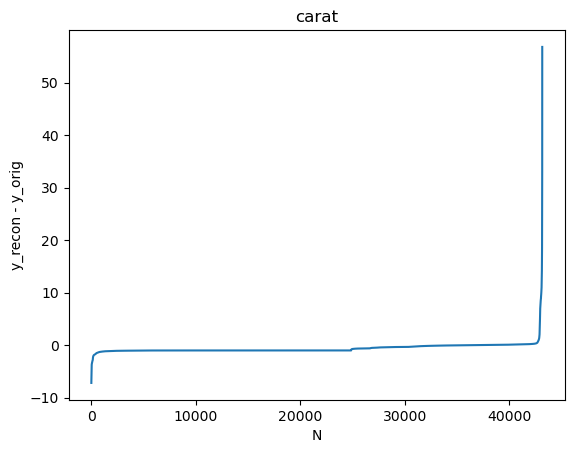

In [23]:
# visualize performance of the reconstructor
feature_index = 0 # choose feature index
#####

fnames = copy.deepcopy(featurelist_num)
fnames.remove('price')
fname = fnames[feature_index]
reconstructed_data_cpu = reconstructed_data.cpu().detach().numpy()  # Move to CPU and detach from computation graph
y_recon = reconstructed_data_cpu[:,feature_index]
y_orig = X_scaled_train[:,feature_index]
dy = (y_recon - y_orig) / y_orig
plt.plot(np.sort(dy), '-')
plt.title(fname)
plt.ylabel('y_recon - y_orig')
plt.xlabel('N')

print(fname)
print(pd.Series(dy).describe())

In [24]:
# prepare the equivalent latent features
model_encoder.eval()
X_tensor_train = torch.tensor(X_scaled_train, dtype=torch.float32).to(device)
X_tensor_val = torch.tensor(X_scaled_val, dtype=torch.float32).to(device)
with torch.no_grad():  # No gradients needed during inference
    Z_train = model_encoder.encoder(X_tensor_train)
    Z_val = model_encoder.encoder(X_tensor_val)

In [ ]:
# prepare DMatrix for xgboost
DT_X = xgb.DMatrix(X_scaled_train, Y_scaled_train, enable_categorical=False) # Training X features
DT_Z = xgb.DMatrix(Z_train, Y_scaled_train, enable_categorical=False) # Training Z (latent) features
DV_X = xgb.DMatrix(X_scaled_val, Y_scaled_val, enable_categorical=False) # Validation X features
DV_Z = xgb.DMatrix(Z_val, Y_scaled_val, enable_categorical=False) # Validation Z features

In [28]:
# xgboost params
params_gpu = {
    "objective": "reg:squarederror", 
    'eval_metric': 'rmse',
    "tree_method": "hist",
    'device': 'gpu'
    }
ve = 50
es = 50
evals_X = [(DT_X, 'Xtrain'), (DV_X, 'Xval')]
evals_Z = [(DT_Z, 'Ztrain'), (DV_Z, 'Zval')]
N = 200


In [29]:
# xgboost train, X features
tic = time.time()
model_X = xgb.train(
   params=params_gpu,
   dtrain=DT_X,
   num_boost_round=N,
   evals=evals_X,
   verbose_eval=ve,
   # early_stopping_rounds=es,
)
toc = time.time()
print(f'Training took {toc - tic} seconds.\n')

[0]	Xtrain-rmse:0.74196	Xval-rmse:0.74045
[50]	Xtrain-rmse:0.29868	Xval-rmse:0.33850
[100]	Xtrain-rmse:0.27695	Xval-rmse:0.34041
[150]	Xtrain-rmse:0.25899	Xval-rmse:0.34166
[199]	Xtrain-rmse:0.24634	Xval-rmse:0.34374
Training took 0.5790975093841553 seconds.



In [30]:
# xgboost train, Z features
tic = time.time()
model_Z = xgb.train(
   params=params_gpu,
   dtrain=DT_Z,
   num_boost_round=N,
   evals=evals_Z,
   verbose_eval=ve,
   # early_stopping_rounds=es,
)
toc = time.time()
print(f'Training took {toc - tic} seconds.\n')

[0]	Ztrain-rmse:0.75628	Zval-rmse:0.75453
[50]	Ztrain-rmse:0.32532	Zval-rmse:0.35731
[100]	Ztrain-rmse:0.30719	Zval-rmse:0.36042
[150]	Ztrain-rmse:0.29399	Zval-rmse:0.36259
[199]	Ztrain-rmse:0.28346	Zval-rmse:0.36378
Training took 0.44267749786376953 seconds.



In [31]:
# Note a similar performance between model_X and model_Z
# However, model_Z trained using latent Z features. There are 3 Z-features, instead of 6 X-features.
X_scaled_val.shape, Z_val.shape

((10788, 6), torch.Size([10788, 3]))

Text(0.5, 0, 'sorted N')

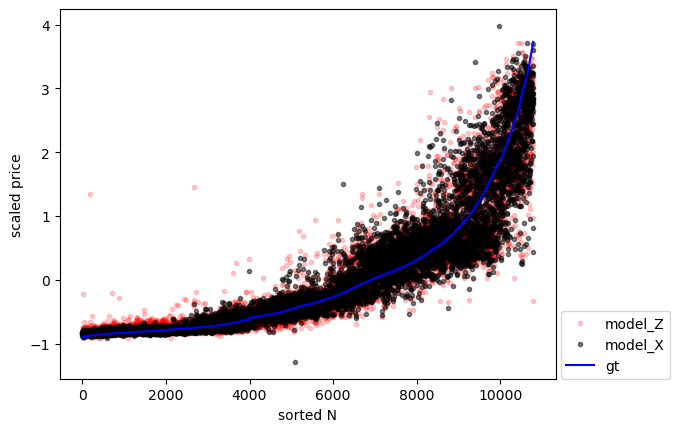

In [46]:
# visualization
o = np.argsort(Y_scaled_val) # sort using gt
plt.plot(model_Z.predict(DV_Z)[o], marker='.', ls='', color='red', alpha=0.2, label='model_Z')
plt.plot(model_X.predict(DV_X)[o], marker='.', ls='', color='black', alpha=0.5, label='model_X')
plt.plot(Y_scaled_val[o], color='blue', label='gt')
plt.legend(loc=(1.01,0))
plt.ylabel('scaled price')
plt.xlabel('sorted N')